## Step 4: Model Comparison
We choose Logistic regression, naive Bayes, decision tree and naive Bayes to do the modelling

In [1]:
#basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn imports
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.metrics import recall_score, f1_score, precision_score
import scipy.stats as sta
from sklearn.model_selection import GridSearchCV


In [2]:
df = pd.read_csv('data_standardized_dumb.csv')
y = df['default']
X = df.drop(['default'],axis=1)

In [3]:
def comparemodels():
    names = ["LogisticRegression",
            "Naive Bayes",
            "Decision Tree",
            "Random Forest"]
    classifiers = [LogisticRegression(solver = 'liblinear'),
                  GaussianNB(),
                  DecisionTreeClassifier(random_state=0),
                  RandomForestClassifier(random_state=0, bootstrap=True)]
    cmaps = ['Reds',
            'Greens',
            'Blues',
            'Oranges']
    fig, axe1 = plt. subplots(nrows=1, ncols=1, figsize=(8,4))
    fig, axe = plt. subplots(nrows=2, ncols=2, figsize=(8, 2*4))
    valuation = pd.DataFrame()

    LR_param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    LR_param_grid = {'C': LR_param_range}
    
    NB_param_grid = {}
    
    DT_max_depth_range = [1, 5, 10, 15, 20, 25]
    DT_criterion_range = ['gini', 'entropy']
    DT_param_grid = {'criterion': DT_criterion_range, 'max_depth': DT_max_depth_range}
    
    RF_n_estimators_range = [10, 20, 30]
    RF_max_depth_range = [1, 5, 10, 15, 20, 25]
    RF_criterion_range = ['gini', 'entropy']
    RF_param_grid = {'n_estimators': RF_n_estimators_range, 'max_depth': RF_max_depth_range, 'criterion': RF_criterion_range}
    

    grids = [LR_param_grid,
            NB_param_grid,
            DT_param_grid,
            RF_param_grid]


    for name, clf, ax, cmap, param_grid in zip(names, classifiers, axe.ravel(), cmaps, grids):
        
        grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10)
        grid_search.fit(X_train,y_train) 
        print("Test set score:{:.2f}".format(grid_search.score(X_test,y_test)))
        print("Best parameters:{}".format(grid_search.best_params_))
        print("Best score on train set:{:.2f}".format(grid_search.best_score_))          
        
        y_pred = grid_search.predict(X_test)    
        y_score = grid_search.predict_proba(X_test)[:, 1]
        
        score = grid_search.score(X_test, y_test)
        precision = round(precision_score(y_true=y_test, y_pred=y_pred),2)
        recall = round(recall_score(y_true=y_test, y_pred=y_pred),2)
        f1 = round(f1_score(y_true=y_test, y_pred=y_pred),2)
        temp = pd.DataFrame({
            'precision_score':[precision],
            'recall':[recall],
            'f1_score':f1
        },index = [name])
        
#         temp = pd.DataFrame([precision_score,recall,f1_score],columns = [clf])
        valuation = valuation.append(temp)
        #if(cmap == 'Oranges'):
           # tmp_fi = pd.Series(clf.feature_importances_)
        
        confmatrix = confusion_matrix(y_test, y_pred)
        true0, true1 = [sum(confmatrix[i]) for i in [0,1]]
        pred0, pred1 = [sum(i) for i in zip(*confmatrix)]
        #need to check whether tpr is right
        tpr=confmatrix[1,1]/true1
        
        ylabels = ['Not default: {}'.format(true0), 'Default: {}'.format(true1)]
        xlabels = ['Not default: {}'.format(pred0), 'Default: {}'.format(pred1)]

        
        sns.heatmap(confusion_matrix(y_test, y_pred),
                   annot = True,
                   xticklabels = xlabels,
                   yticklabels = ylabels,
                   fmt = 'g',
                   ax = ax,
                   vmax = len(X_test),
                   vmin = 0,
                   cbar = False,
                   cmap = cmap)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Truth')
        ax.set_title('{} (Score: {},TPR:{})'.format(name, np.round(score, decimals=3),np.round(tpr, decimals=3)), size=12)
        #ax.set_title('{} (Score: {})'.format(name, np.round(score, decimals=3)), size=14)
        fpr, tpr, thresholds = roc_curve(y_test, y_score, drop_intermediate=False, pos_label=1)
        axe1.set_ylabel('True Positive Rate')
        axe1.set_xlabel('False Positive Rate')
        
        axe1.plot([0,1], [0,1], c = 'black')
        axe1.set_title('AUC of Algorithms')
        roc_auc = auc(fpr, tpr)
        axe1.plot (fpr, tpr, label = 'ROC fold %s (area = %0.2f)' %(name, roc_auc))
        axe1.legend(prop={'size': 11}, loc = 'lower right')

    return fig, confmatrix, valuation

Test set score:0.70
Best parameters:{'C': 0.001}
Best score on train set:0.70
Test set score:0.69
Best parameters:{}
Best score on train set:0.69
Test set score:0.86
Best parameters:{'criterion': 'gini', 'max_depth': 25}
Best score on train set:0.86
Test set score:0.93
Best parameters:{'criterion': 'gini', 'max_depth': 25, 'n_estimators': 30}
Best score on train set:0.92


,precision_score,recall,f1_score
LogisticRegression,0.80,0.52,0.63
Naive Bayes,0.76,0.56,0.65
Decision Tree,0.81,0.94,0.87
Random Forest,0.90,0.96,0.93


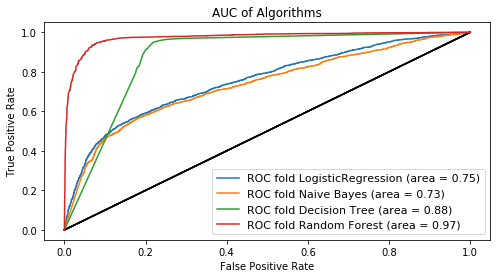

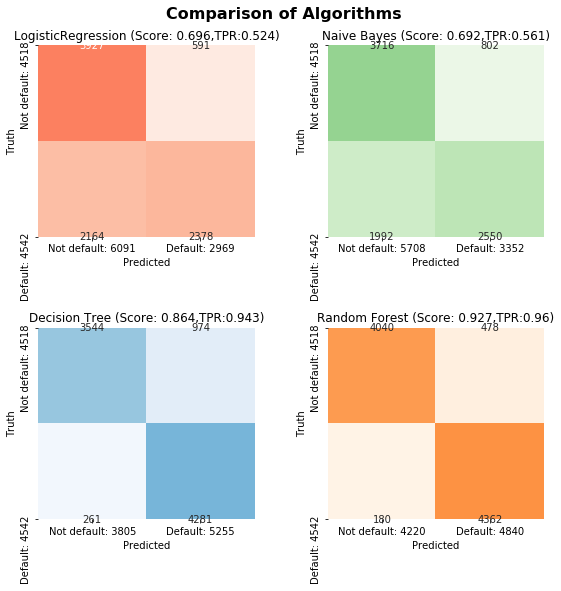

In [4]:
X_upsampled, y_upsampled = resample(X[y == 1], y[y == 1],replace=True,
                                    n_samples=X[y == 0].shape[0], random_state=123)
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))
X = pd.DataFrame(X_bal,columns = X.columns)
y = y_bal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)
fig, confmatrix,valuation = comparemodels()
plt.suptitle('Comparison of Algorithms', y=1.02, size=16, weight='bold')
plt.tight_layout()
valuation